# Molecular Dynamics Simulations of Lennard-Jones gases, liquids and solids in the canonical ensemble

Ralf Everaers, ENS Lyon (2021)

This notebook serves a double purpose:

    1) to reinforce your culture of running and analysing simulations
    2) to document the emergence of gaseous, liquid and crystalline phases in a simple model system, LJ systems in the canonical NVT-ensemble


You will study 2d LJ systems at two densities ($\rho = 0.3 \sigma^{-2}$ and $\rho = 0.82 \sigma^{-2}$) and a different temperatures below and above the critical temperature $k_BT \approx 0.5 \epsilon$. The objective is to observe characteristic features of condensed matter in the gaseous, liquid and solid state.


References:

    The gas-liquid transition of the two-dimensional Lennard-Jones fluid, M Rovere, D W Heermann and K Binder, Journal of Physics: Condensed Matter, Volume 2, Number 33 (1990)
    
    Phase diagram of the two-dimensional Lennard-Jones system; Evidence for first-order transitions, J.A.Barker, D.Henderson and F.F.Abraham, Physica A: Statistical Mechanics and its Applications, Volume 106, Issues 1–2, March 1981, Pages 226-238

In [2]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import math
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

You can make the systems even smaller, if you find that the notebook runs too slowly. Note that larger systems also require longer times to equilibrate. The required effort thus increases faster than just linearly with the number of particles.

In [3]:
# define system
d=2
NParticles=64
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time    

# define the length of the trajectory
run_time = 100. * tau

## A 2d Lennard-Jones fluid far above the critical point

### A first trajectory

In [4]:
#choose temperature
kT = 4.0

# choose density
rho = 0.3/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,number_of_time_steps_between_stored_configurations=1)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  14.60593486680443
Execution time:  54.53049846399995


### Animate trajectory

We can animate at the stored configurations ....

100 100


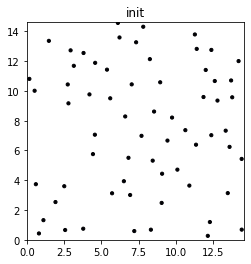

In [5]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (t_tr.size-1)/(x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(t_tr[::skip_t],x_tr[::skip_x],y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

### Pressure

... inspect the time evolution of the pressure ...

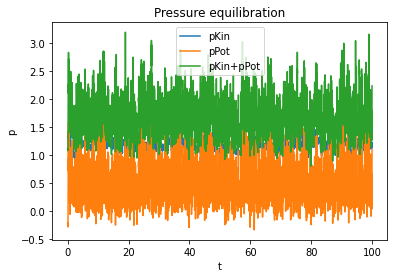

In [6]:
plt.plot(t_tr,pKin_tr,label="pKin")
plt.plot(t_tr,pPot_tr,label="pPot")
plt.plot(t_tr,pKin_tr+pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

### Energy

... and of the internal energy and its components:

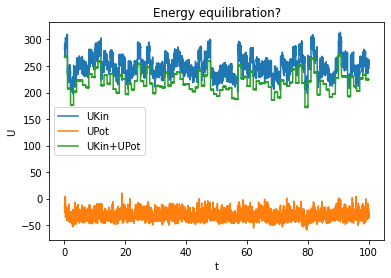

In [7]:
max_t = -1
plt.plot(t_tr[:max_t],uKin_tr[:max_t],label="UKin")
plt.plot(t_tr[:max_t],uPot_tr[:max_t],label="UPot")
plt.plot(t_tr[:max_t],uKin_tr[:max_t]+uPot_tr[:max_t],label="UKin+UPot")
plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy equilibration?")
plt.legend()

### Radial distribution function

The pair correlation function measures the probability to find particle at particular distances from a test particle relative to the ideal gas value.

64 particles in one configuration
10000 data sets
r_range (0, 5)
bins 100
14617244.0  pair distances
40320000  expected
14844025.288211772 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

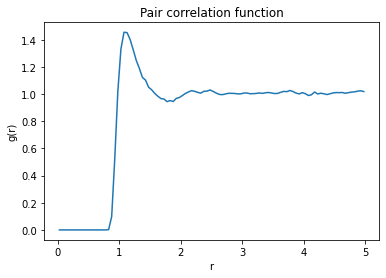

In [8]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(x_tr,y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

Integrating the pair correlation function up to a cutoff distance yields the number of neighbor particles contained in a spherical volume centered on a test particle.

Text(0, 0.5, 'N(r)')

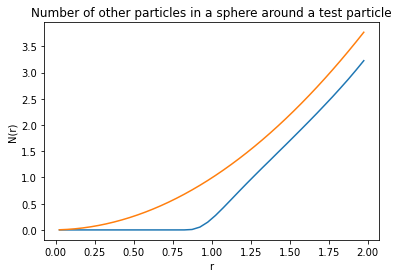

In [9]:
last_bin = 40
number_of_neighbors_up_to_a_distance = np.cumsum(g*rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
ideal_number_of_neighbors_up_to_a_distance = np.cumsum(rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],number_of_neighbors_up_to_a_distance[:last_bin])
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],ideal_number_of_neighbors_up_to_a_distance[:last_bin])
plt.title("Number of other particles in a sphere around a test particle")
plt.xlabel("r")
plt.ylabel("N(r)")

While the above graph gives the AVERAGE number of neighbor particles, it is also interesting to explore the full distribution. A bimodal distribution might be a hint, that the system has undergone a phase separation.

Text(0, 0.5, 'p(n)')

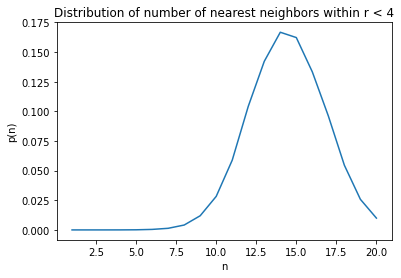

In [10]:
r_max = 4

nnn_hist, nnn_bin_edges = np.histogram(MD.Number_of_nearest_neighbors(2,LBox,(x_tr,y_tr),r_max), 20, (0.5,20.5),normed=None, weights=None, density=True)

plt.plot(MD.BinCenters(nnn_bin_edges),nnn_hist)
plt.title("Distribution of number of nearest neighbors within r < "+str(r_max))
plt.xlabel("n")
plt.ylabel("p(n)")

### Particle trajectories, mean-square displacements and diffusion constant

It always instructive to look at the raw data and simply plot the particle trajectories.

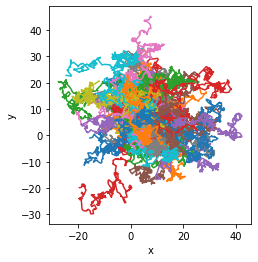

In [11]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

For a more quantitative analysis one calculates the particle mean-square displacemenents as a function of time.

In [12]:
delta_t, x_msd = MD.MeanSquareDisplacements(t_tr,x_tr)
delta_t, y_msd = MD.MeanSquareDisplacements(t_tr,y_tr)

The two results for the msd in the x- and y-direction already give us a little idea for the error bar.

Do you understand the first regime?

Plotting msd/t has the advantage, that we see directly, if we have reached the asymptotic diffusive regime, where this ratio becomes a constant. 

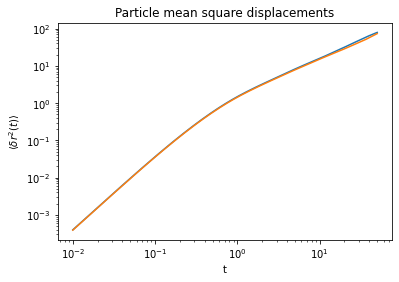

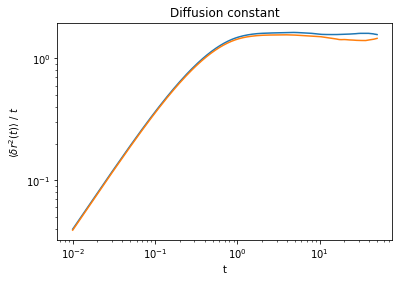

In [13]:
plt.title("Particle mean square displacements")
plt.xlabel("t")
plt.ylabel(r"$\langle \delta r^2(t) \rangle$")
plt.loglog(delta_t,x_msd)
plt.loglog(delta_t,y_msd)
plt.show()

plt.title("Diffusion constant")
plt.xlabel("t")
plt.ylabel(r"$\langle \delta r^2(t) \rangle \ /\ t$")
plt.loglog(delta_t,x_msd/delta_t)
plt.loglog(delta_t,y_msd/delta_t)

### Second run with the system inserted into a much larger box

It is instructive to observe the behavior, if the system is allowed to freely expand into a much larger volume.

In [14]:
# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.01/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  80.0
Execution time:  60.540160301000014


100 100


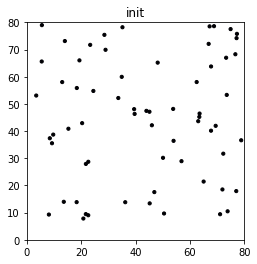

In [342]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

## Your turn: A supercritical 2d Lennard-Jones fluid

Keep the density $\rho = 0.3 \sigma^{-2}$, but reduce the temperature to $k_BT = 1.0 \epsilon$.

In [52]:
#choose temperature
kT = 1.0

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.03/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  46.188021535170066
Execution time:  68.69797188499979


In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

64 particles in one configuration
10000 data sets
r_range (0, 5)
bins 100
0.0  pair distances
40320000  expected
1484402.5288211768 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

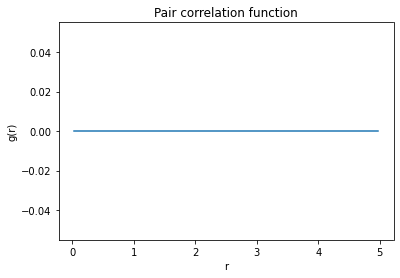

In [53]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr,new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

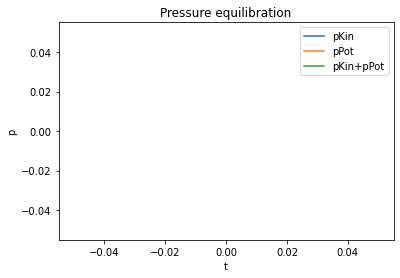

In [54]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

## Your turn: A 2d Lennard-Jones fluid close to the critical point  

Keep the density $\rho = 0.3 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.5 \epsilon$.

In [55]:
#choose temperature
kT = 0.5

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.03/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  46.188021535170066
Execution time:  58.14313625499926


In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

64 particles in one configuration
10000 data sets
r_range (0, 5)
bins 100
0.0  pair distances
40320000  expected
1484402.5288211768 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

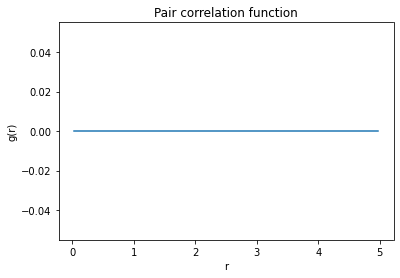

In [56]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

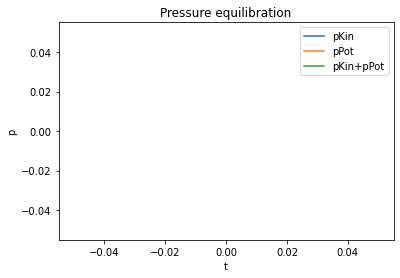

In [57]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

## Your turn: Phase separation in a 2d Lennard-Jones fluid below the critical temperature

Keep the density $\rho = 0.3 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.45 \epsilon$.

In [ ]:
#choose temperature
kT = 0.45

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.03/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

## Your turn: Phase separation in a 2d Lennard-Jones fluid below the critical temperature

Keep the density $\rho = 0.3 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.4 \epsilon$.

In [ ]:
#choose temperature
kT = 0.4

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.03/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

## Your turn: A high-density 2d Lennard-Jones system at high temperature

Now increase the density to $\rho = 0.82 \sigma^{-2}$. We start again with the very high temperature of $k_BT = 4.0 \epsilon$.


In [ ]:
#choose temperature
kT = 4.0

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.82/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

Is the system liquid or solid?

For this series of simulations I found it useful to preserve the end states of the simulations at high density as starting states for subsequent runs. Can you modify the script accordingly?

## Your turn: A high-density 2d Lennard-Jones system at the critical temperature

Keep the density $\rho = 0.82 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.5 \epsilon$.

In [ ]:
#choose temperature
kT = 0.5

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.82/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

Is the system liquid or solid?

## Your turn: A high-density 2d Lennard-Jones system at half the critical temperature

Keep the density $\rho = 0.82 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.25 \epsilon$.

In [ ]:
#choose temperature
kT = 0.25

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.82/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

Is the system liquid or solid?

## Your turn: A high-density 2d Lennard-Jones system at one quarter of the critical temperature

Keep the density $\rho = 0.82 \sigma^{-2}$, but reduce the temperature to $k_BT = 0.125 \epsilon$.

In [ ]:
#choose temperature
kT = 0.125

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.82/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

In [ ]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(new_x_tr, new_y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

In [ ]:
plt.plot(new_t_tr,new_pKin_tr,label="pKin")
plt.plot(new_t_tr,new_pPot_tr,label="pPot")
plt.plot(new_t_tr,new_pKin_tr+new_pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

Is the system liquid or solid?

## Your turn: Increase the number of particles and run a long simulation to study the phase separation in a 2d Lennard-Jones fluid below the critical temperature

Choose again the lower density $\rho = 0.3 \sigma^{-2}$ and run the simulation at a temperature of $k_BT = 0.4 \epsilon$ or even lower.

This is going to take some time. It is probably a good idea to no longer store the configuration after each and every time step. Or you could even try to implement the trick I showed you, when we looked at the same problem for the Ising/lattice-gas model: storing configurations at exponentially increasing time intervals!

In [ ]:
#choose temperature
kT = 0.4

# place particle back into the original simulation box
x = MD.FoldIntoBox((2*LBox,3*LBox),x)
y = MD.FoldIntoBox((2*LBox,3*LBox),y)

# choose new average density
rho = 0.3/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                    starting_configuration=[t,x,y,vx,vy],
                                                    number_of_time_steps_between_stored_configurations=1,
                                                    number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

In [ ]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but configurations were potentially stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip_x=100
skip_t=int( (new_t_tr.size-1)/(new_x_tr.shape[0]-1) )*skip_x

print(skip_x,skip_t)

MD.AnimateMDRun(new_t_tr[::skip_t],new_x_tr[::skip_x],new_y_tr[::skip_x],xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)